In [1]:
# !pip install -U transformers matplotlib scipy nbdev fastcore accelerate datasets git+https://github.com/huggingface/diffusers Pillow==9.4.0 torchmetrics wandb

In [2]:
#|default_exp train

In [3]:
# from local_secrets import hf_token, wandb_key
# from huggingface_hub import login
# import wandb

# login(token=hf_token)
# wandb.login(key=wandb_key)

In [1]:
#|export
import torch, torch.nn.functional as F, random, wandb, time, contextlib
import torchvision.transforms as T
import torch.distributed as dist
import bitsandbytes as bnb
from torchvision import transforms
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel
from diffusers import AutoencoderDC, SanaTransformer2DModel
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from transformers import AutoModel, AutoTokenizer, set_seed, get_constant_schedule_with_warmup
from datasets import load_dataset, Dataset, DatasetDict
from tqdm import tqdm
from functools import partial
from types import SimpleNamespace
from statistics import mean

from utils import (
    generate,
    plot_density, 
    pil_add_text, 
    latent_to_PIL, 
    make_grid, 
    encode_prompt, 
    dcae_scalingf, 
    pil_clipscore, 
    free_memory, 
    get_rnd_sigmas,
    get_sigma_schedule,
    load_imagenet_1k_vl_enriched_recaped
)

seed = 42
set_seed(seed)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [5]:
#|export
def load_models(text_encoder, transformer_repo, ae, dtype, device):
    if ".json" in transformer_repo:
        transformer = SanaTransformer2DModel.from_config(transformer_repo).to(device).to(dtype)
    else:
        transformer = SanaTransformer2DModel.from_pretrained(transformer_repo).to(device).to(dtype)

    te = AutoModel.from_pretrained(text_encoder, torch_dtype=dtype).to(device)
    tok = AutoTokenizer.from_pretrained(text_encoder, torch_dtype=dtype)
    dcae = AutoencoderDC.from_pretrained(ae, subfolder="vae", torch_dtype=dtype).to(device)

    if debug:
        print(f"Transformer parameters: {sum(p.numel() for p in transformer.parameters()) / 1e6:.2f}M")
        print(f"DCAE parameters: {sum(p.numel() for p in dcae.parameters()) / 1e6:.2f}M")

    return transformer, te, tok, dcae

def add_random_noise(latents, dist, timesteps=1000):
    bs = latents.size(0)
    noise = torch.randn_like(latents)
    sigmas = get_rnd_sigmas(bs, dist=dist).to(latents.device)  # floats 0-1 of dist specified in train_config
    timesteps = (sigmas * timesteps).to(latents.device)   # yes, `timesteps = sigmas * 1000`, let's keep it simple
    sigmas = sigmas.view([latents.size(0), *([1] * len(latents.shape[1:]))])
    
    latents_noisy = (1 - sigmas) * latents + sigmas * noise # (1-noise_level) * latent + noise_level * noise

    return latents_noisy.to(latents.dtype), noise, timesteps

def eval_loss(dataloader_eval, testing=False):
    losses = []

    for batch_num, (labels, latents, prompts_encoded, prompts_atnmask) in tqdm(enumerate(dataloader_eval), "eval_loss"):
        latents = latents * dcae_scalingf
        latents_noisy, noise, t = add_random_noise(latents, dist=train_config.sigma_sampling)
        with torch.no_grad():
            noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
    
        loss = F.mse_loss(noise_pred, noise - latents)
        losses.append(loss.item())  
        if testing: break
    return sum(losses)/len(losses)

In [6]:
#|export
dtype = torch.bfloat16
device = "cuda" 
debug = True
ddp = True

model_config = SimpleNamespace(
    text_encoder = "HuggingFaceTB/SmolLM2-360M",
    transformer_from = "transformer_Sana-DiT-XL-smollm2.json",
    ae = "Efficient-Large-Model/Sana_600M_1024px_diffusers",
)

data_config = SimpleNamespace(
    dataset = "g-ronimo/IN1k256-AR-buckets-bfl16latents_dc-ae-f32c32-sana-1.0",
    col_label = "label",
    col_latent = "latent",
    splits_train = ["train_AR_1_to_1", "train_AR_3_to_4", "train_AR_4_to_3"],
    splits_eval = ["validation_AR_1_to_1", "validation_AR_3_to_4", "validation_AR_4_to_3"],
)

train_config = SimpleNamespace(
    version = "alpha42",
    lr = 1e-4,
    bs = 64,
    gradient_accumulation_steps = 4,
    epochs = 100,
    resume_from_step = 30_000,
    steps_warmup = 500,
    steps_log = 10,
    steps_eval = 1300,
    epochs_save = 1,
    timesteps_training = 1000,
    sigma_sampling = "normal",  # beta uniform normal
    grad_checkpointing = False,
    log_wandb = True,
    wandb_project = "Hana",
    wandb_run = "{version}-{size:.2f}M_LR-{lr}_BS-{bs}_GAS-{gas}_{ws}x{device}",
)

eval_config = SimpleNamespace(
    prompts = [
        "a collection of comic books on a table",
        "a green plant with a green stem",
        "an airplane in the sky",
        "two fighter jets on the red sky",
        "a blonde girl",
        "a red car",
        "a blue car",
        "a cheeseburger on a white plate", 
        "a bunch of bananas on a wooden table", 
        "a white tea pot on a wooden table", 
        "an erupting volcano with lava pouring out",
    ],
    seeds = [6945, 4009, 1479, 8141, 3441], # seeds for latent generation
    inference_config = dict(
        num_steps = 20, 
        guidance_scale = 7,
        latent_dim = [1, 32, 8, 8]  # 128x128px
    )
)

In [7]:
#|export

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

in1k_recaps = load_imagenet_1k_vl_enriched_recaped()

class ImageNet96ARDataset(torch.utils.data.Dataset):
    def __init__(
        self, hf_dataset, splits, text_enc, tokenizer, bs, ddp=False, col_id="image_id", col_label="label", col_latent="latent"
    ):
        self.hf_dataset = hf_dataset
        self.splits = splits  # each split is one aspect ratio
        self.col_label, self.col_latent, self.col_id = col_label, col_latent, col_id
        self.text_enc, self.tokenizer =  text_enc, tokenizer
        self.tokenizer.padding_side = "right"
        self.prompt_len = 50

        # Create a dataloader for each split (=aspect ratio)
        self.dataloaders = {}
        self.samplers = {}
        for split in splits:
            if ddp: 
                self.samplers[split] = DistributedSampler(hf_dataset[split], shuffle=True, seed=seed)
            else: 
                self.samplers[split] = RandomSampler(hf_dataset[split], generator=torch.manual_seed(seed))

            self.dataloaders[split] = DataLoader(
                hf_dataset[split], sampler=self.samplers[split], collate_fn=self.collate, batch_size=bs, 
                num_workers=4, prefetch_factor=2
            )

    def collate(self, items):
        labels = [
            # random pick between md2, qwen2 and smolvlm
            in1k_recaps[i[self.col_id]][random.randint(0, 2)]
            for i in items
        ]
        # latents shape [B, 1, 32, W, H] -> squeeze [B, 32, W, H]
        latents = torch.Tensor([i[self.col_latent] for i in items]).squeeze()

        return labels, latents

    def encode_prompts(self, prompts):
        prompts_tok = self.tokenizer(
            prompts, padding="max_length", truncation=True, max_length=self.prompt_len, return_attention_mask=True, return_tensors="pt"
        )
        with torch.no_grad():
            prompts_encoded = self.text_enc(**prompts_tok.to(self.text_enc.device))
        return prompts_encoded.last_hidden_state, prompts_tok.attention_mask

    def __iter__(self):
        # Reset iterators at the beginning of each epoch
        iterators = { split: iter(dataloader) for split, dataloader in self.dataloaders.items() }
        active_dataloaders = set(self.splits)  # Track exhausted dataloaders
        current_split_index = -1
        
        while active_dataloaders:
            # Round robin: change split on every iteration (=after every batch OR after we unsucc. tried to get a batch) 
            current_split_index = (current_split_index + 1) % len(self.splits)
            split = self.splits[current_split_index]

            # Skip if this dataloader is exhausted
            if split not in active_dataloaders: continue
            
            # Try to get the next batch
            try:
                labels, latents = next(iterators[split]) 
                label_embs, label_atnmasks = self.encode_prompts(labels)
                latents = latents.to(dtype).to(device)
                yield labels, latents, label_embs, label_atnmasks
            # dataloader is exhausted
            except StopIteration: active_dataloaders.remove(split)

    def __len__(self):
        return sum([len(self.dataloaders[split]) for split in self.splits])

    def set_epoch(self, epoch):
        for split in self.splits: self.samplers[split].set_epoch(epoch)

In [8]:
# DON'T EXPORT
ddp = False

In [9]:
#|export
if ddp:
    dist.init_process_group(backend='nccl')
    is_master = dist.get_rank() == 0  
    world_size = dist.get_world_size()
    local_rank = dist.get_rank()
    torch.cuda.set_device(local_rank)
    debug = debug and is_master
else:
    # Running on single GPU or in notebook
    is_master = True
    world_size = 1
    local_rank = 0

transformer, text_encoder, tokenizer, dcae = load_models(
    text_encoder = model_config.text_encoder,
    transformer_repo = model_config.transformer_from,
    ae = model_config.ae,
    dtype = dtype,
    device = device
)

if "SmolLM2" in model_config.text_encoder:
    tokenizer.pad_token = tokenizer.eos_token

if train_config.grad_checkpointing:
    transformer.enable_gradient_checkpointing()

if ddp:
	transformer = DistributedDataParallel(transformer, device_ids=[local_rank])
    
ds = load_dataset(data_config.dataset)

dataloader_train = ImageNet96ARDataset(
    ds, splits=data_config.splits_train, text_enc=text_encoder, tokenizer=tokenizer, bs=train_config.bs, ddp=ddp
)
dataloader_eval = ImageNet96ARDataset(
    # ddp = false, we want a random sampler, not the distributed samples, in any case
    ds, splits=data_config.splits_eval, text_enc=text_encoder, tokenizer=tokenizer, bs=train_config.bs, ddp=False
)

optimizer = bnb.optim.AdamW8bit(transformer.parameters(), lr=train_config.lr)
lr_scheduler = get_constant_schedule_with_warmup(optimizer, train_config.steps_warmup)

wandb_run = train_config.wandb_run.format(
    version=train_config.version,
    size=sum(p.numel() for p in transformer.parameters())/1e6, 
    lr=train_config.lr, 
    bs=train_config.bs, 
    gas=train_config.gradient_accumulation_steps,
    ws=world_size,
    device=device,
)

steps_epoch = sum([len(ds[split]) for split in data_config.splits_train]) // (train_config.bs * train_config.gradient_accumulation_steps * world_size)
if is_master: print(f"steps per epoch: {steps_epoch}")

/home/g/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.load_config(...) followed by <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


Transformer parameters: 590.20M
DCAE parameters: 312.25M


Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

steps per epoch: 16857


Sigma distribution:


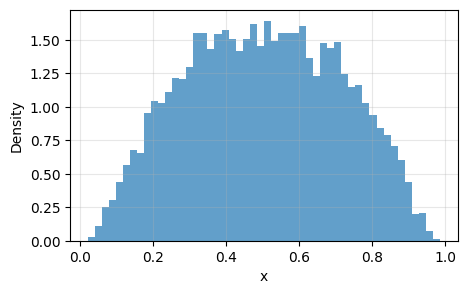

Testing noising:


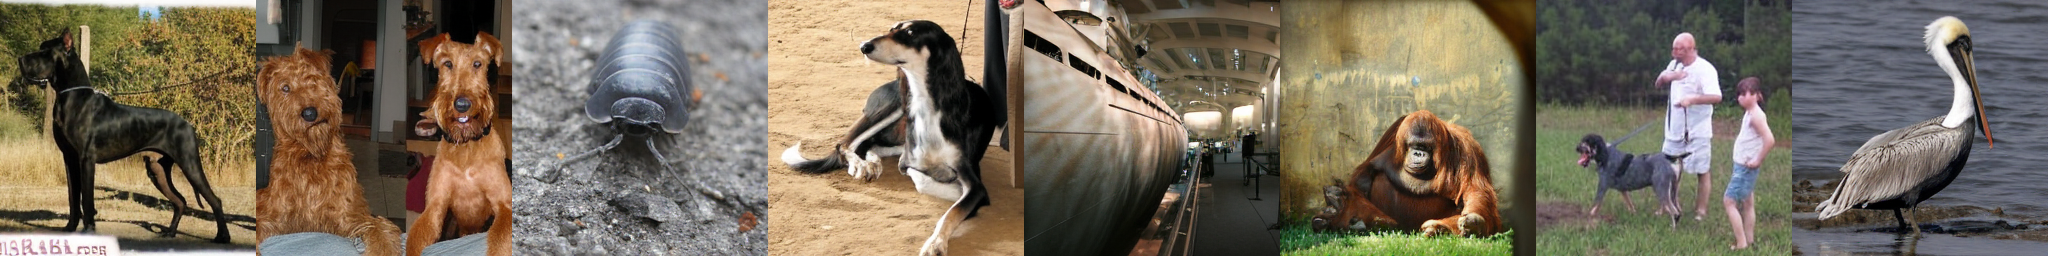

timesteps rounded [733, 404, 332, 792, 351, 800, 694, 197]


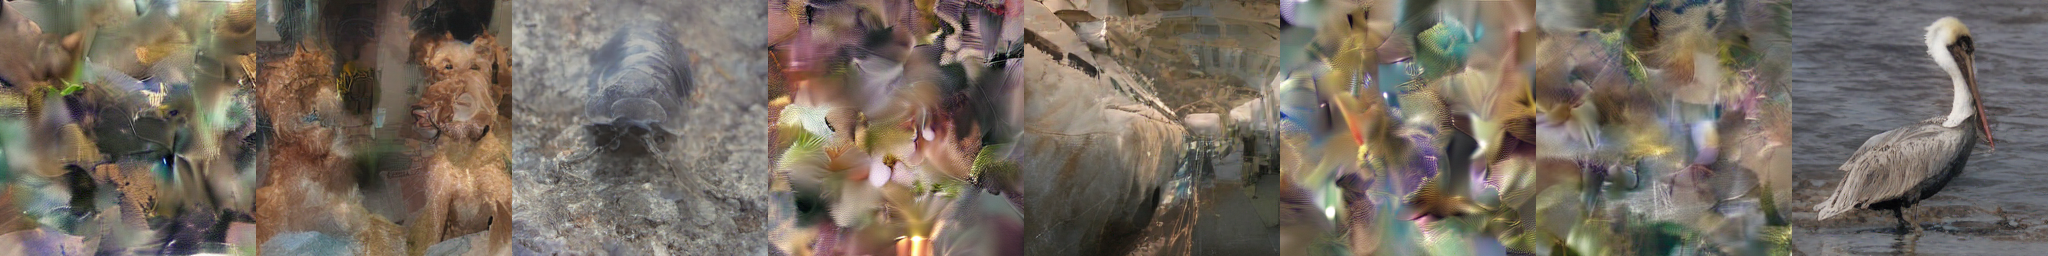

Eval prompts:
[(0, 'a collection of comic books on a table'), (1, 'a green plant with a green stem'), (2, 'an airplane in the sky'), (3, 'two fighter jets on the red sky'), (4, 'a blonde girl'), (5, 'a red car'), (6, 'a blue car'), (7, 'a cheeseburger on a white plate'), (8, 'a bunch of bananas on a wooden table'), (9, 'a white tea pot on a wooden table'), (10, 'an erupting volcano with lava pouring out')]
Inspecting first batch


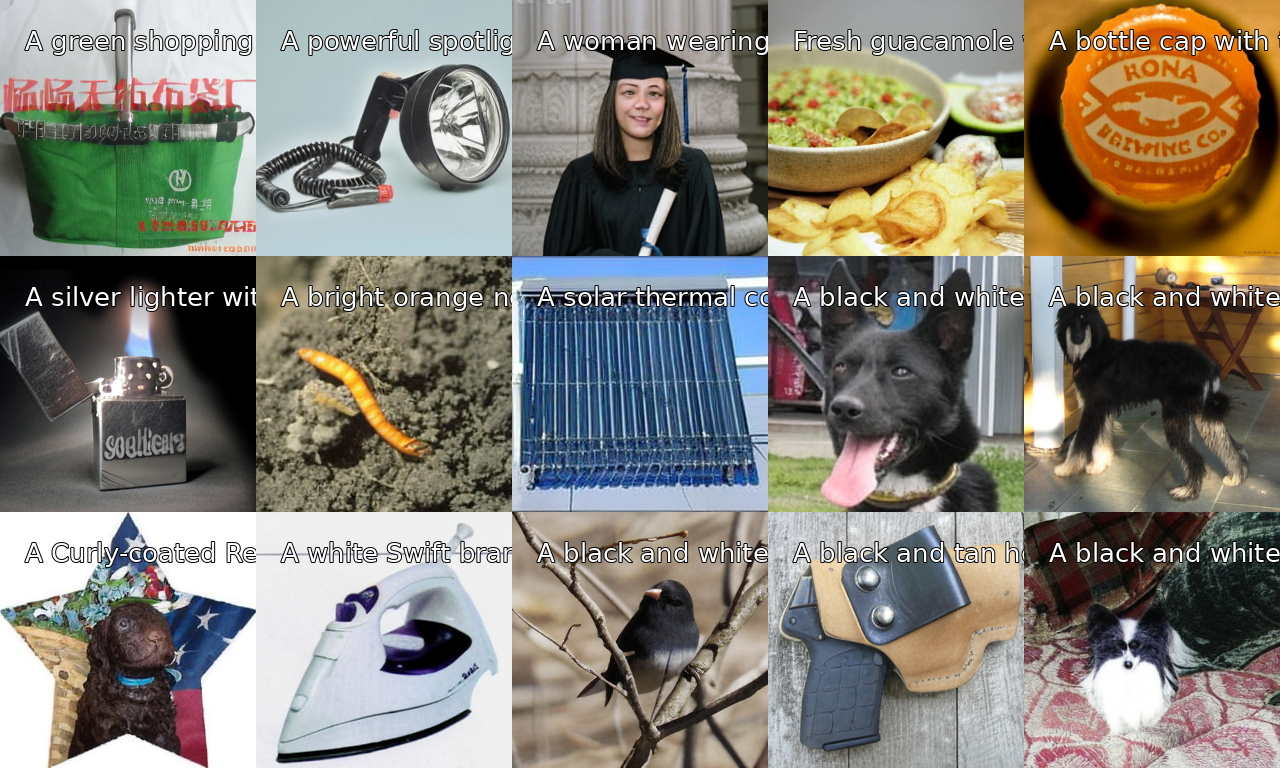

Testing generate


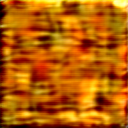

Testing eval loss


eval_loss: 0it [00:01, ?it/s]


2.4375
Testing eval images and clip score


eval_images: 100%|████████████████████████████████████████| 11/11 [00:08<00:00,  1.31it/s]


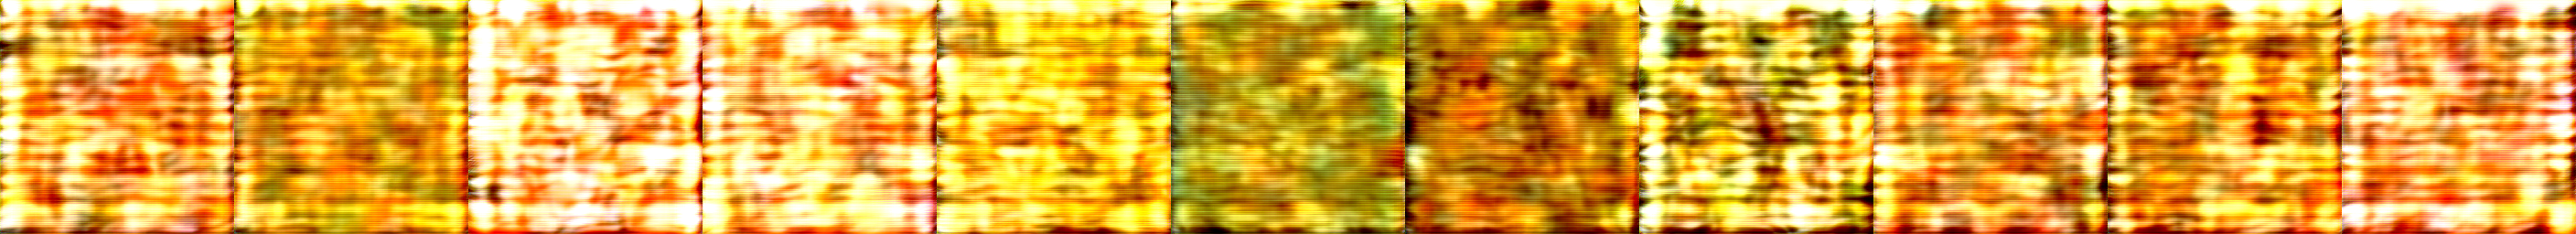

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


21.484970092773438


In [11]:
# DONT EXPORT
if is_master: 
    print("Sigma distribution:")
    sigmas = get_rnd_sigmas(10_000, train_config.sigma_sampling)
    plot_density(sigmas)

    print("Testing noising:")
    def test_noising():
        labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader_train))
        # latents=latents.to(dtype).to(device)
        latent=latents[0:8,:] * dcae_scalingf
        display(make_grid(latent_to_PIL(latent / dcae_scalingf,dcae)))
        
        latent_noisy, noise, timesteps = add_random_noise(latent, dist=train_config.sigma_sampling)
        
        print("timesteps rounded", list(map(round, timesteps.tolist())))
        display(make_grid(latent_to_PIL(latent_noisy / dcae_scalingf,dcae)))
    test_noising()

    print("Eval prompts:")
    print(list(enumerate(eval_config.prompts)))
    
    print("Inspecting first batch")
    def show_first_batch(dataloader):
        labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader))
        # latents=latents.to(dtype).to(device)
        images = [pil_add_text(latent_to_PIL(latent[None, :], dcae), str(label)) for label, latent in zip(labels[:20], latents[:20])]
        display(make_grid(images[:15], 3, 5))
    show_first_batch(dataloader_train)
    
    print("Testing generate")
    display(generate("horse", transformer, tokenizer, text_encoder, dcae, **eval_config.inference_config).resize((128,128)))
    
    print("Testing eval loss")
    print(eval_loss(dataloader_eval, testing=True))
    
    print("Testing eval images and clip score")
    images = [
        generate(p, transformer, tokenizer, text_encoder, dcae, **eval_config.inference_config) 
        for p in tqdm(eval_config.prompts, "eval_images")
    ]
    display(make_grid(images))
    print(pil_clipscore(images, eval_config.prompts))

# Train

In [23]:
import nbdev; nbdev.export.nb_export(__session__)

In [13]:
#|export

if is_master and train_config.log_wandb: 
    if wandb.run is not None: wandb.finish()
    wandb.init(
        project=train_config.wandb_project, 
        name=wandb_run
    ).log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb") or path.endswith(".json"))

last_step_time = time.time()
step = train_config.resume_from_step if train_config.resume_from_step is not None else 0
step_loss, sample_count, last_sample_count = 0, 0, 0
time_dataload, time_dataload_start = 0, time.time()
free_memory()

for epoch in range(train_config.epochs):
    if ddp: dataloader_train.set_epoch(epoch)
    accumulation_step = 0
    
    for batch_idx, (labels, latents, prompts_encoded, prompts_atnmask) in enumerate(dataloader_train):  
        accumulation_step += 1
        time_dataload += time.time() - time_dataload_start

        if ddp and train_config.gradient_accumulation_steps > 1 and accumulation_step % train_config.gradient_accumulation_steps != 0:
            context = transformer.no_sync()
        else:
            context = contextlib.nullcontext()

        latents = latents * dcae_scalingf
        latents_noisy, noise, t = add_random_noise(latents, dist = train_config.sigma_sampling)

        with context:
            noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
            loss = F.mse_loss(noise_pred, noise - latents)        
            loss = loss / train_config.gradient_accumulation_steps
            loss.backward()

            step_loss += loss.cpu().detach().item() 
            sample_count += len(labels)

        if (accumulation_step % train_config.gradient_accumulation_steps == 0) or (accumulation_step==len(dataloader_train)):
            grad_norm = torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()
            lr_scheduler.step()

            step += 1

            # Log step
            if is_master and step>0 and step % train_config.steps_log == 0:
                step_time = (time.time() - last_step_time) / train_config.steps_log * 1000
                sample_count_glob = sample_count * world_size
                sample_tp = (sample_count_glob-last_sample_count) / (time.time() - last_step_time)
                log_lr = lr_scheduler.get_last_lr()[0]
                dl_time = (time_dataload / train_config.steps_log) if step > train_config.steps_log else None
                print(f"step {step}, epoch: {step / steps_epoch:.2f}, train loss: {step_loss:.4f}, grad_norm: {grad_norm:.2f}, lr: {log_lr:.5f}, {step_time:.2f}ms/step, {sample_tp:.2f}samples/sec")
                if train_config.log_wandb: 
                    wandb.log({"loss_train": step_loss, "grad_norm": grad_norm, "step_time": step_time, "step": step, "sample_tp": sample_tp, "sample_count": sample_count_glob, "epoch": step / steps_epoch, "dl_time": dl_time, "lr": log_lr})
                last_step_time = time.time()
                last_sample_count = sample_count_glob
                time_dataload = 0

            # Eval step
            if is_master and step>0 and step % train_config.steps_eval == 0:
                transformer.eval()
                loss_eval = eval_loss(dataloader_eval)
                sample_count = step * train_config.bs * world_size

                # try different seeds for generating eval images
                images_eval = [
                    generate(
                        p, transformer, tokenizer, text_encoder, dcae, latent_seed=seed, **eval_config.inference_config
                    ) 
                    for seed in tqdm(eval_config.seeds, "eval_images")
                    for p in eval_config.prompts
                ]
                clipscore = pil_clipscore(images_eval, eval_config.prompts * len(eval_config.seeds))
                # add labels before logging the images
                images_eval = make_grid([
                    pil_add_text(img, eval_config.prompts[i % len(eval_config.prompts)]) 
                    for i, img in enumerate(images_eval)
                ], rows=len(eval_config.seeds), cols=len(eval_config.prompts))
                print(f"step {step}, eval loss: {loss_eval:.4f}, clipscore: {clipscore:.2f}")
                if train_config.log_wandb: 
                    wandb.log({"loss_eval": loss_eval, "clipscore": clipscore, "images_eval": wandb.Image(images_eval), "step": step, "sample_count": sample_count, "epoch": step / steps_epoch})
                transformer.train()  

            # reset step loss after (maybe) logging it
            step_loss = 0
            time_dataload_start = time.time()

    
    if ddp: torch.distributed.barrier()  # sync before save? don't know, let's be safe
    if is_master and epoch % train_config.epochs_save == 0:
        if ddp: transformer.module.save_pretrained(f"cp-e{epoch}")
        else: transformer.save_pretrained(f"cp-e{epoch}")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: g-ronimo. Use `wandb login --relogin` to force relogin


step 10, epoch: 0.00, train loss: 1.8906, grad_norm: 1.61, 1025.89ms/step, 74.08samples/sec
step 20, epoch: 0.00, train loss: 1.8359, grad_norm: 1.30, 747.38ms/step, 101.69samples/sec
step 30, epoch: 0.00, train loss: 1.8516, grad_norm: 0.77, 742.26ms/step, 102.39samples/sec
step 40, epoch: 0.00, train loss: 1.7812, grad_norm: 1.44, 756.66ms/step, 100.44samples/sec
step 50, epoch: 0.00, train loss: 1.7734, grad_norm: 1.20, 757.68ms/step, 100.31samples/sec
step 60, epoch: 0.00, train loss: 1.7500, grad_norm: 1.14, 747.54ms/step, 101.67samples/sec


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7212be0617e0>
Traceback (most recent call last):
  File "/home/g/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/home/g/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
#|export
if ddp: torch.distributed.barrier()

if is_master:
    wandb.finish()
    transformer.module.push_to_hub(f"g-ronimo/hana-{train_config.version}")

if ddp: dist.destroy_process_group()